# Ejercicio 2

## Leer datos

In [1]:
import pandas as pd
import numpy as np
import operator

# news_data = pd.read_excel('datasets/Noticias_argentinas.xlsx', na_values=['NA'], usecols="A:D")
news_data = pd.read_excel('datasets/Noticias_argentinas.xlsx')

news_data = news_data.loc[news_data['categoria'].notnull()]

In [2]:
import numpy as np
EXPECTED_BY_CATEGORY= {
    'Internacional': 3850,
    'Nacional': 3860,
    'Destacadas': 3859,
    'Deportes': 3855,
    'Salud': 3840,
    'Ciencia y Tecnologia': 3856,
    'Entretenimiento': 3850,
    'Economia': 3850,
    'Noticias destacadas': 133819
}

print(len(news_data[news_data['categoria'] == 'Nacional']))
for k,v in EXPECTED_BY_CATEGORY.items():
    print(f"Categoria: {k}")
    actual = len(news_data[news_data['categoria'] == k])
    print(f"Expected: {v}, Actual: {actual}, Diff: {abs(actual -v)}")

# Total da raro pero el resto como debe
# print("Total")
# print(f"Expected: {EXPECTED_TOTAL}, Actual: {len(news_data)}, Diff: {abs(len(news_data) - EXPECTED_TOTAL)}")

3860
Categoria: Internacional
Expected: 3850, Actual: 3850, Diff: 0
Categoria: Nacional
Expected: 3860, Actual: 3860, Diff: 0
Categoria: Destacadas
Expected: 3859, Actual: 3859, Diff: 0
Categoria: Deportes
Expected: 3855, Actual: 3855, Diff: 0
Categoria: Salud
Expected: 3840, Actual: 3840, Diff: 0
Categoria: Ciencia y Tecnologia
Expected: 3856, Actual: 3856, Diff: 0
Categoria: Entretenimiento
Expected: 3850, Actual: 3850, Diff: 0
Categoria: Economia
Expected: 3850, Actual: 3850, Diff: 0
Categoria: Noticias destacadas
Expected: 133819, Actual: 133819, Diff: 0


In [9]:
class Category:

    def __init__(self, name):
        self.name = name
        self.headline_count = 0
        self.probability = 0
        self.words = {}
        self.relative_frequencies = {}
        self.probability_of_no_data = 0

    def add_words_from_headline(self, headline):
        
        self.headline_count += 1

        keys = headline.lower().split()
        key_set = list(set(keys))

        for key in key_set:
        	# processed[key] = keys.count(key)
        	if key not in self.words.keys():
	            self.words[key] = 0
	        self.words[key] = self.words.get(key) + keys.count(key)  


    def learn(self, total_headlines):
	    # probability of each word
	    k = len(self.words.keys())
	    total = sum(self.words.values())
	    self.probability = self.headline_count / total_headlines
	    self.probability_of_no_data = 1 / (total + k)

	    for word, cardinal in self.words.items():
	    	self.relative_frequencies[word] = (cardinal + 1) / (total + k)


    def get_productorial(self, headline):
        words = headline.lower().split()

        prod = 1

        for word in words:
            prod = prod * self.probability_of_no_data if word not in self.relative_frequencies.keys() \
                else self.relative_frequencies.get(word)

        # for word in words:
        # 	if word not in self.relative_frequencies.keys():
        # 		prod = prod * self.probability_of_no_data
        # 	else:
        # 		prod = prod * self.relative_frequencies.get(word)

        return prod * self.probability


class Bayes:

    def __init__(self, df):
        self.categories = {}
        self.confusion_matrix = {}
        self.roc = []

        for headline, category in zip(df['titular'], df['categoria']):
	        if category not in self.categories.keys():
	            self.categories[category] = Category(category)
	        self.categories[category].add_words_from_headline(headline)

    def learn(self, total_headlines):
    	for category in self.categories.values():
    		category.learn(total_headlines)
    	print("Bayes learning finished.")


    def classify(self, testing_data):

        self.confusion_matrix = {
            category: {category: 0 for category in self.categories.keys()}
            for category in self.categories.keys()
        }

        for i in range(len(testing_data)):
            row = testing_data.iloc[i]
            headline = row.titular
            current = row.categoria

            productorial = {}
            for name, category in self.categories.items():
            	productorial[name] = category.get_productorial(headline)

            winner = max(productorial.items(), key = operator.itemgetter(1))[0]

            self.confusion_matrix[current][winner] += 1

            productorial_sum = sum(productorial.values())

            probabilities = {}
            for name, productorial in productorial.items():
            	probabilities[name] = productorial/productorial_sum	

            probabilities["category"] = current
            self.roc.append(probabilities)
            


In [10]:
def split_dataframe(df, percentage):

    msk = np.random.rand(len(df)) < percentage
    training_data = df[msk]
    testing_data = df[~msk]

    return training_data, testing_data


In [11]:

categories_filter = [
    'Salud',
    'Deportes',
    'Economia',
    'Ciencia y Tecnologia',
    'Entretenimiento',
    'Nacional',
    'Internacional'
]

news_data = news_data.loc[news_data['categoria'].isin(categories_filter)]

print(len(news_data.index))

26961


In [16]:
training_data, testing_data = split_dataframe(news_data, percentage = 0.8)

In [17]:
bayes = Bayes(training_data)

bayes.learn(len(news_data.index))

bayes.classify(testing_data)
confusion_matrix = bayes.confusion_matrix
pd.DataFrame.from_dict(confusion_matrix, orient='index')

Bayes learning finished.


,Nacional,Deportes,Salud,Ciencia y Tecnologia,Entretenimiento,Economia,Internacional
Nacional,522,37,58,22,34,67,55
Deportes,38,584,36,23,28,45,39
Salud,23,9,642,29,8,20,16
Ciencia y Tecnologia,11,16,32,600,8,47,16
Entretenimiento,39,42,35,53,499,34,44
Economia,26,9,53,59,4,569,57
Internacional,80,31,49,32,26,77,508


## Metricas

In [18]:
def true_positive(matrix, class_name):
    return matrix[class_name][class_name]

def true_negative(matrix, class_name):
    count = 0
    for i in matrix.keys():
        if i != class_name:
            for j in matrix[i].keys():
                if j != class_name:
                    count += matrix[i][j]
    return count

def false_negative(matrix, class_name):
    count = 0
    for i in matrix[class_name].keys():
        if i != class_name:
            count += matrix[i][class_name]
    return count

def false_positive(matrix, class_name):
    count = 0
    for i in matrix[class_name].keys():
        if i != class_name:
            count += matrix[class_name][i]
    return count

def accuracy(tp,tn,fp, fn):
    return (tp+tn)/(tp+tn+fn+fp)

def precision(tp,fp):
    return tp/(tp+fp)

def recall(tp,fn):
    return tp/(tp+fn)

def f1_score(p, r):
    return (2*p*r)/(p+r)

def tp_rate(tp, fn):
    return tp/(tp+fn)

def fp_rate(fp, tn):
    return fp/(fp+tn)


def metrics_table(matrix):
    to_return={}
    
    for k in matrix.keys():
        to_return[k]={}
        to_return[k]['tp'] = tp = true_positive(matrix, k)
        to_return[k]['tn'] = tn = true_negative(matrix, k)
        to_return[k]['fp'] = fp = false_positive(matrix, k)
        to_return[k]['fn'] = fn = false_negative(matrix, k)
        to_return[k]['accuracy'] = accuracy(tp, tn, fp, fn)
        to_return[k]['precision']= p = precision(tp, fp)
        to_return[k]['recall'] = r = recall(tp, fn)
        to_return[k]['f1_score'] = f1_score(p, r)
        to_return[k]['tp_rate'] = tp_rate(tp, fn)
        to_return[k]['fp_rate'] = fp_rate(fp, tn)
    return to_return

metrics = metrics_table(confusion_matrix)
pd.DataFrame.from_dict(metrics, orient='index')

,tp,tn,fp,fn,accuracy,precision,recall,f1_score,tp_rate,fp_rate
Nacional,522,4379,273,217,0.909108,0.656604,0.706360,0.680574,0.706360,0.058684
Deportes,584,4454,209,144,0.934520,0.736444,0.802198,0.767916,0.802198,0.044821
Salud,642,4381,105,263,0.931738,0.859438,0.709392,0.777240,0.709392,0.023406
Ciencia y Tecnologia,600,4443,130,218,0.935448,0.821918,0.733496,0.775194,0.733496,0.028428
Entretenimiento,499,4537,247,108,0.934150,0.668901,0.822076,0.737620,0.822076,0.051630
Economia,569,4324,208,290,0.907624,0.732304,0.662398,0.695599,0.662398,0.045896
Internacional,508,4361,295,227,0.903172,0.632628,0.691156,0.660598,0.691156,0.063359


## ROC

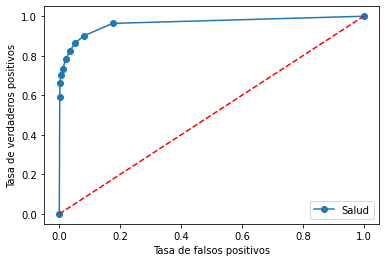

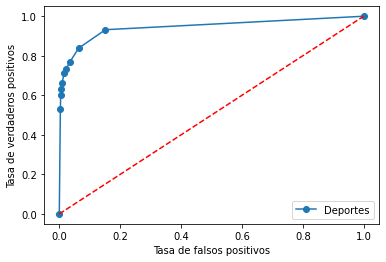

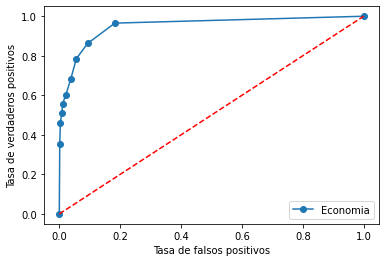

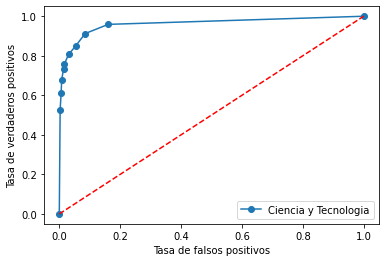

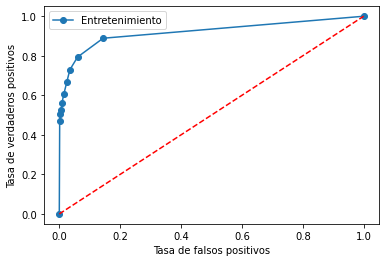

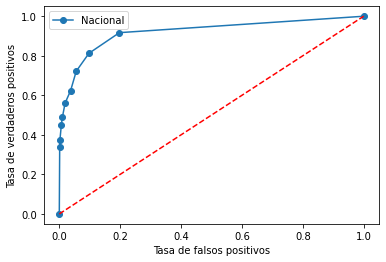

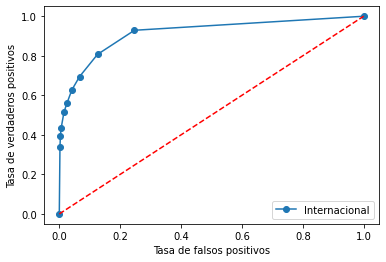

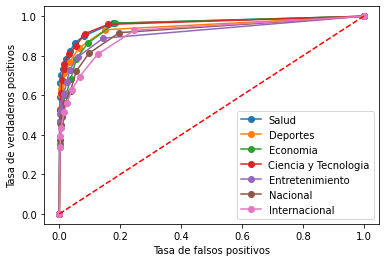

In [20]:
import matplotlib.pyplot as plt
def plot_roc(roc):
    categories = categories_filter

    roc_curve = {
        category: {
            "total_fp": [],
            "total_tp": []
        } for category in categories
    }

    threshold = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for category in categories:
        for u in threshold:
            tp = 0
            fp = 0
            tn = 0
            fn = 0

            for sample_probabilities in roc:
                if sample_probabilities["category"] == category:
                    if sample_probabilities[category] > u:
                        tp += 1
                    else:
                        fn += 1 
                else:
                    if sample_probabilities[category] > u:
                        fp += 1
                    else: 
                        tn += 1

            total_tp = tp / (tp + fn)
            total_fp = fp / (fp + tn)
            roc_curve[category]["total_fp"].append(total_fp)
            roc_curve[category]["total_tp"].append(total_tp)

    for category in categories:
        plt.plot(roc_curve[category]["total_fp"], roc_curve[category]["total_tp"], "-o", label = category)
        line = threshold
        plt.plot(line,line, "--", color="red")
        axes = plt.gca()
        axes.set_xlim([-0.05,1.05])
        axes.set_ylim([-0.05,1.05])
        plt.xlabel("Tasa de falsos positivos")
        plt.ylabel("Tasa de verdaderos positivos")
        plt.legend()
        plt.show()


    for category in categories:
        plt.plot(roc_curve[category]["total_fp"], roc_curve[category]["total_tp"], "-o", label = category)
        
    line = threshold
    plt.plot(line,line, "--", color="red")
    axes = plt.gca()
    axes.set_xlim([-0.05,1.05])
    axes.set_ylim([-0.05,1.05])
    plt.xlabel("Tasa de falsos positivos")
    plt.ylabel("Tasa de verdaderos positivos")
    plt.legend()
    plt.show()


plot_roc(bayes.roc)